<DIV ALIGN=CENTER>

# Introduction to Neo4J
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

Previously, we introduced networks and graph data structures by using
the Python NetworkX library. While we could save those graphs to a file
in different format, that did not provide the benefits of a database For
example, we did not have transactional support, powerful query
mechanism, or distributed, multi-user support. As a result, in this
Notebook, we will introduce a graph database, specifically, Neo4J, that
provides robust database support for graph data structures. Neo4J is, of
course, a complicated software technology. Therefore, we will only
introduce the basic Neo4J concepts in this Notebook. The reference
documentation for [Neo4J][nj] and [py2neo][p2] provide a complete
coverage of these software tools.

-----

[nj]: http://neo4j.com/developer/get-started/
[p2]: http://py2neo.org

## Python and Neo4J

To use Python to interact with Neo4J, we need to use a suitable Python
library. The recommended Python library is [_py2neo_][py2neo], which
provides support for establishing a connection between a Python program
and a Neo4J database as well as support tools for working with Neo4J. The lateest version, **V3**, is still in _Beta_ and is not very well documented at the moment. However, the [previous version][py2neo2] has a more thorough documentation that is mostly relevant.

We have already installed _py2neo_ in the course Docker container;
however, you can easily install is by using `pip`, for example to
install _py2neo_ for use with Python3 for the current user, we can
execute:

```bash
pip3 install py2neo==3b1 --user
```

Once this library is installed, we can import necessary classes from the Neo4J client to
establish a connection and retrieve data and Neo4J information. In particular this will include `authentication` and `Graph`, which will allow us to establish a connection to a remote database.

```python
from py2neo import authenticate, Graph
```

-----

[py2neo]: http://py2neo.org/v3/
[py2neo2]: http://py2neo.org/2.0/

In [1]:
from py2neo import authenticate, Graph

-----

## Local Neo4J Server

To open a connection to the localhost using py2neo, we establish a new
Neo4J Graph:

```python
graph = Graph()
```

which assumes a local server with default port. Alternatively, we can
explicitly list the hostname and port, which is preferred since it is
easier to recognize the server and port number, which can be easily
changed when we move to a remote Neo4J server.

```python
graph = Graph("http://localhost:7474")
```

which connects to the local Neo4J database using the default local host
name and port, and assumes a default database of `db/data`.

-----

## Remote Neo4J Server

To connect to a remote Neo4J server, for instance by using the course
Neo4J database, hosted by Microsoft Azure, we simply need the IP address
for the server and the port number on which the Neo4J database is
listening. For this course, Notebooks running on the course JupyterHub
Server can access a Neo4J server on `65.52.38.138` and the default port
number of `7474`:

```python
graph = Graph("http://65.52.38.138:7474")
```

which connects to the local Neo4J database using the default local host
name and port, and assumes a default database of `db/data`. To specify a
different database, we can explicitly change this name in the URL. For
example, to connect to the `bigdog` database:

```python
graph = Graph("http://65.52.38.138:7474/db/bigdog")
```

Since this server requires authentication, we must create call the
authentication method and supply the course username and password, which
are shown in the code cell. Note, do not attempt to interfere with other
students databases. Logging is enabled on the server and you will suffer
an instructor determined point reduction.

-----

In the following code cell, we read in the current user's netid to
obtain a unique database name for this Notebook.

-----

In [2]:
# Filename containing user's netid
fname = '/home/data_scientist/users.txt'
with open(fname, 'r') as fin:
    netid = fin.readline().rstrip()

# We will delete our working directory if it exists before recreating.
dbname = '{0}'.format(netid)

In [3]:
host_ip = '65.52.38.138:7474'
username = 'neo4j'
password = 'Lcdm#info490'

# First we authenticate
authenticate(host_port=host_ip, user=username, password=password)

# Now create database URL
db_url = 'http://{0}/db/{1}'.format(host_ip, dbname)

print('Creating connection to {0}'.format(db_url))
graph = Graph(db_url)

version = graph.dbms.kernel_version
print('Neo4J Kernel version {0}.{1}.{2}'.format(version[0], version[1], version[2]))

Creating connection to http://65.52.38.138:7474/db/bigdog
Neo4J Kernel version 2.3.3


-----

### Monitor database communication

The Neo4J driver provides support for monitoring communication between
the Python database application (for example, this Notebook) and the
database server. In py2neo version 3.0, this [monitoring][mon] can be
done at two levels:

1. HTTP Traffic: `neo4j.http`
2. Bolt Traffic: `py2neo.cypher`

where `http` is for web communication and `bolt` is the new Neo4J binary
protocol. For example, to enable monitoring of the HTTP and Neo4J
communication:

```python
from py2neo import watch
watch('neo4j.http')
watch('neo4j.bolt')
```

This will enable all communication to be viewed, which can be very
helpful in learning to use Neo4J from Python or debugging. Note that
once enabled, however, these monitors remain active. You can set the
[logging level][ll] in the method creation (which is different from
py2neo version 2.0). For example, `level=logging.NOTSET` implies no
logging. Alternatively, you can remove the watch statements, restart the
IPython kernel, and rerun the Notebook.

```python
import logging
watch('neo4j.http', level=logging.NOTSET)
```

-----

[mon]: http://py2neo.org/2.0/cookbook.html
[ll]: https://docs.python.org/3.5/library/logging.html#levels



In [4]:
# Execute simply Cypher command to test database
# From pyneo v3 Documentation
graph.run('UNWIND range(1, 10) AS n RETURN n, n*n as n_sq').dump()

 n   n_sq 
----------
  1     1 
  2     4 
  3     9 
  4    16 
  5    25 
  6    36 
  7    49 
  8    64 
  9    81 
 10   100 


-----

## Deleting all graphs

To remove all graphs from a Neo4J server, we can simply call the
`delete_all` method on the server connection. We will use this
repeatedly in this Notebook in order to clean up the server and to
prevent cell outputs from being overwhelmed with graph data. In general,
however, this should be used with great care since it all data in the
graph database will be deleted.

-----

In [5]:
# Clean out graph database
graph.delete_all()

-----

## Creating Graphs

A graph data structure is composed of nodes and relationships (or
edges). The nodes and relationships can also have associated
attributes. Neo4J has classes for these structures, but to make them
persistent, information has to be communicated to the database server.
As was the case with relational databases, Neo4J supports the concept of
transactions, or logical unit of work.  By default, instructing the
Neo4J server to create an object is wrapped in a single transaction. For
example, we can create a new node and instruct the database server to
persist the new node by using the following code:

```python
nd = Node()
graph.create(nd)
```

In this case, we create and persist a node with no label or other
attributes, which can will complicate searching for this particular
node. Instead, we can create and persist a node with a label. This is
demonstrated in the following code cells, where we create a single node
before creating multiple nodes. We find the nodes of interest by using
the `graph.find` method. By providing a label name, we find all nodes
with the indicated label

-----

In [6]:
from py2neo import Node

test = Node('Students')
graph.create(test)

for node in graph.find('Students'):
    print(node)

(cfc02c3:Students)


In [7]:
for x in range(1, 6):
    node = Node('Students')
    graph.create(node)

for node in graph.find('Students'):
    print(node)
    
print('\nNode Labels:\n', 40*'-')
for node in graph.node_labels:
    print(node)

(cfc02c3:Students)
(b4b308b:Students)
(ab220eb:Students)
(e17958f:Students)
(e3c0fdb:Students)
(a2cd91f:Students)

Node Labels:
 ----------------------------------------
Students


-----

### Node Attributes

We can add attributes to a Node either when the node is created, or
after the node has been created and persisted. To add an attribute
during node creation, simply pass the attribute name and the attribute
value in the Node constructor:

```python
nd = Node('Label', attr = value)
graph.create(nd)
```

On the other hand, when a node has already been created, we can use
dictionary style access to create a new attribute. However, since the node
has already been created, we do not use the `create` method to persist
the changes. Instead, we _push_ the changes to the server as follows:

```python
nd['attr'] = value
graph.push(nd)
```

We demonstrate both of these approaches in the following code cell.

-----

In [8]:
# Create a node with an attribute
test2 = Node('Students', name='Test 2')
graph.create(test2)

# Add an attribute to existing node
test['name'] = 'Test 1'
graph.push(test)

for node in graph.find('Students'):
    print(node)
    
# Remove all nodes to start fresh.
graph.delete_all()

(cfc02c3:Students {name:"Test 1"})
(b4b308b:Students)
(ab220eb:Students)
(e17958f:Students)
(e3c0fdb:Students)
(a2cd91f:Students)
(test_2:Students {name:"Test 2"})


-----

## Relationships

A key component of graph data structures are the relationships (or
edges) between nodes. In Neo4J, a relationship is created between two
nodes with a connection type. For example, given two nodes corresponding
to different people, a connection type might be `'boss of'` or 
`'spouse of'`. If no connection type is provided, a default type 
of `'TO'` is used. 

In the following codes cells, we first create two `Students` nodes
before creating a relationship of `'sister of'` between the `jane` and
`john` nodes. Following this, we display the connection types that are
persisted in the database before displaying the relationship between the
two nodes. In this case, we use the `graph.match` method to find all
relationship that start from a given node.

-----

In [9]:
from py2neo import Relationship
# Create two nodes

jane = Node('Students', name='Jane Doe')
john = Node('Students', name='John Doe')

jj = Relationship(jane, 'sister of', john)
graph.create(jj)

for node in graph.find('Students'):
    print(node)


(jane_doe:Students {name:"Jane Doe"})
(john_doe:Students {name:"John Doe"})


In [10]:
for edge in graph.relationship_types:
    print(edge)

for edge in graph.match(start_node=jane):
    print(edge)

sister of
(jane_doe)-[:`sister of`]->(john_doe)


----

### Relationship Attributes

Like nodes, relationships can have attributes, which enable additional
information to be included in a graphical model. Once again, attributes
can be either added when the relationship is created or they can be
added, dictionary style with the subsequent change pushed to the
database server. In the following code cells, we first demonstrate
adding a new attribute to the relationship between the two nodes: `jane`
and `john`, before adding a new relationship with an attribute between
these two nodes .

----

In [11]:
# Adding attribute to relationship (edge)
jj['began'] = 2001
graph.push(jj)

for edge in graph.match(start_node=jane):
    print(edge)

(jane_doe)-[:`sister of` {began:2001}]->(john_doe)


In [12]:
# Bidrectional relationship    
jj2 = Relationship(john, 'brother of', jane, began = 2001)
graph.create(jj2)

for node in [jane, john]:
    for edge in graph.match(start_node=node):
        print(edge)    

(jane_doe)-[:`sister of` {began:2001}]->(john_doe)
(john_doe)-[:`brother of` {began:2001}]->(jane_doe)


-----

### Retrieving

In previous examples, we demonstrated the `graph.find` method to
retrieve nodes from the graph database. By default, the `find` method
searches for nodes with a given label. However, you can also include
attributes and attribute values by passing in values for the
`property_key` and `property_value` parameters. Likewise, we can pass a
value for the `rel_type` parameter to the `graph.match` method to find
relationships between nodes that have a specific connection type.

The following code cell demonstrates this idea to first search for nodes
with `name = 'John Doe'`, after which we search for relationships that
start from `jane` and have `rel_type='sister of'` connection types.


-----

In [13]:
for node in graph.find('Students', property_key = 'name', property_value='John Doe'):
    print(node)
    
for node in graph.match(start_node=jane, rel_type='sister of'):
    print(node)

(john_doe:Students {name:"John Doe"})
(jane_doe)-[:`sister of` {began:2001}]->(john_doe)


-----

## Updating Graphs

Once created, we can modify the attributes of a node or relationship by
using dictionary style access. This is demonstrated in the following
code cell, where we change the value of the `name` attribute on the
`jane` node and the `began` attribute on the relationship between the
`jane` and `john` nodes.  This might seem minor in comparison to update
processes in other types of databases, however, updates in a graph are
generally restricted to attributes (or properties) of the nodes and
relationships. Otherwise we must delete and recreate nodes and
relationships, which is a much bigger task.

-----

In [14]:
# Modifying attribute to relationship (edge)

jane['name'] = 'Jan Doe'
jj['began'] = 2002

graph.push(jj)

print('Find Modified Node:\n', 40*'-')
for node in graph.find('Students', property_key = 'name', property_value='Jan Doe'):
    print(node)

print()
print('Find Modified Edge:\n', 40*'-')
for edge in graph.match(start_node=jane):
    print(edge)

Find Modified Node:
 ----------------------------------------
(jane_doe:Students {name:"Jan Doe"})

Find Modified Edge:
 ----------------------------------------
(jane_doe)-[:`sister of` {began:2002}]->(john_doe)


-----

## Deleting SubGraphs

We already covered the `delete_all` method, which deletes all nodes and
relationships from a persisted graph. We can also delete individual
nodes or relationships from a graph by using he `delete` method. To
delete a single node, we pass the node as an argument to the `delete`
method. On the other hand, to delete a relationship, we pass the
relationship as an argument to the `delete` method. Note that when
deleting a relationship, any nodes that are _only_ connected to other
nodes via the relationship being deleted will also be deleted.

We demonstrate both of these concepts in the following two code cells.
First we create several new nodes and a relationship between two of them
(mirroring the earlier relationship we created). Next, we delete the
one, isolated node before deleting the relationship, which also deletes
the two nodes. Since the two nodes were created with the relationship,
the two nodes are deleted when the relationship itself is deleted.


-----

In [15]:
# Create temporary nodes and relationships

jim = Node('Students', name='Jim Doe')
jenny = Node('Students', name='Jenny Doe')
jerry = Node('Students', name='Jerry Doe')

jenny['location'] = 'University of Illinois'

jj4 = Relationship(jenny, 'sister of', jim)

graph.create(jj4)
graph.create(jerry)

print('Students:\n', 40*'-')
for node in graph.find('Students'):
    print(node)
    
print('\nRelationships:\n', 40*'-')
for edge in graph.match(rel_type='sister of'):
    print(edge)

Students:
 ----------------------------------------
(jane_doe:Students {name:"Jan Doe"})
(john_doe:Students {name:"John Doe"})
(jenny_doe:Students {location:"University of Illinois",name:"Jenny Doe"})
(jim_doe:Students {name:"Jim Doe"})
(jerry_doe:Students {name:"Jerry Doe"})

Relationships:
 ----------------------------------------
(jane_doe)-[:`sister of` {began:2002}]->(john_doe)
(jenny_doe)-[:`sister of`]->(jim_doe)


In [16]:
graph.delete(jj4)
graph.delete(jerry)


print('Students:\n', 40*'-')
for node in graph.find('Students'):
    print(node)
    
print('\nRelationships:\n', 40*'-')
for edge in graph.match(rel_type='sister of'):
    print(edge)

Students:
 ----------------------------------------
(jane_doe:Students {name:"Jan Doe"})
(john_doe:Students {name:"John Doe"})

Relationships:
 ----------------------------------------
(jane_doe)-[:`sister of` {began:2002}]->(john_doe)


-----

## Persisting Graphs

Previously, we learned how to create and operate on graphs by using the
NetworkX library (and of course there are other graph libraries in
Python, such as igraph). Direct integration between these Python graph
libraries and Neo4J is less than ideal, in large part since Neo4J is
written in Java and designed to work in multiple settings across
different programming languages. 

As a result, the simplest approach to persisting an existing graph
structure is to iterate through the graph, and recreating each node and
edge in Neo4J. This technique is demonstrated in the following code
cells, where we create a NetworkX graph before persisting the graph in
Neo4J. For very large graphs, an alternate approach would be save
the graph to an intermediate file using a format, such as _graphML_,
supported by both graph libraries and import the resulting graph
directly into Neo4J.

When recreating a graph structure in Neo4J, we will be creating many
nodes and relationships. In order to improve performance, we can use a
batch to create multiple nodes and relationships within the same
transaction. To do this, we first obtain a transaction object from the
graph database via the `graph.begin` method. Next, we call the `create`
or `push` method on our new transaction. When we are ready for all
changes to be saved to the database, we call the `commit` method, which
instructs the graph database server to persist all requested changes.

-----

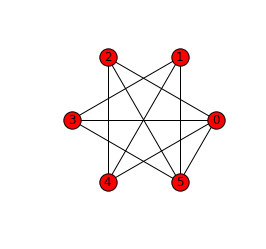

Graph Nodes: [0, 1, 2, 3, 4, 5]
Graph Edges: [(0, 2), (0, 3), (0, 4), (0, 5), (1, 3), (1, 4), (1, 5), (2, 4), (2, 5), (3, 5)]


In [17]:
% matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

hc = nx.complement(nx.path_graph(6))

plt.figure(figsize=(3, 3))
nx.draw_circular(hc, with_labels=True)
plt.show()

print('Graph Nodes:', hc.nodes())
print('Graph Edges:', hc.edges())

In [18]:
# Recreate graph by using a tranascation
tx = graph.begin()

nodes = []
for node in hc.nodes():
    nd = Node('NetworkX', name = str(node))
    nodes.append(nd)
    tx.create(nd)

for edge in hc.edges():
    tx.create(Relationship(nodes[edge[0]], 'Connects To', nodes[edge[1]]))

tx.commit()

In [19]:
# Now query graph database for edges
for node in graph.find('NetworkX'):
    for edge in graph.match(start_node=node):
        print(edge)    

(`0`)-[:`Connects To`]->(`4`)
(`0`)-[:`Connects To`]->(`3`)
(`0`)-[:`Connects To`]->(`2`)
(`0`)-[:`Connects To`]->(`5`)
(`1`)-[:`Connects To`]->(`3`)
(`1`)-[:`Connects To`]->(`4`)
(`1`)-[:`Connects To`]->(`5`)
(`2`)-[:`Connects To`]->(`4`)
(`2`)-[:`Connects To`]->(`5`)
(`3`)-[:`Connects To`]->(`5`)


----

## Graph Querying

Previously in this Notebook, we used Python functions within the py2neo
library to perform database operations. As is the case with many other
databases, however, Neo4J has its own query language, known as
[Cypher][nc]. Everything we have done in this notebook can also be done
via Cypher, and in fact using Cypher is often recommended, even from the
creator of the py2neo library. The output of many of the Python
functions (such as `find` or `match`) is in Cypher representation, thus
you have already seen how to represent nodes and relationships.

In order to perform specific tasks, one simply writes the appropriate
[Cypher query][cq] to `CREATE`, `MATCH`, or `DELETE` nodes and
relationships. In the following code cells, we use Cypher to find nodes,
to find nodes by an attribute, to create nodes, and to create a
relationship between two nodes found from a query. In all cases, we pass
the Cypher query to the graph database by using the `graph.run` method. 

Finally, note that we can also use the `cypher.cypher_repr` method to
see how to represent a particular node or relationship in the Cypher
language. While this function is used in the first node in the following
sequence, the output is used to guide the formatting of the relationship
created in the last code cell.


-----
[nc]: http://neo4j.com/developer/cypher-query-language/
[cq]: http://neo4j.com/docs/stable/cypher-query-lang.html

In [20]:
# Display Cypher representation of a specific relationship
from py2neo.database import cypher

cypher.cypher_repr(jj)

'(jane_doe)-[:`sister of` {began:2002}]->(john_doe)'

In [21]:
# Find nodes by label
for node in graph.run('MATCH (node:Students) RETURN node'):
    print(node)

('node': (jane_doe:Students {name:"Jan Doe"}))
('node': (john_doe:Students {name:"John Doe"}))


In [22]:
# Find specific node by name
for node in graph.run('MATCH (node:Students) WHERE node.name = "John Doe" RETURN node'):
    print(node)

('node': (john_doe:Students {name:"John Doe"}))


In [23]:
# Find node where name ends in value.
for node in graph.run('MATCH (node:Students) WHERE node.name ENDS WITH "Doe" RETURN node'):
    print(node)

('node': (jane_doe:Students {name:"Jan Doe"}))
('node': (john_doe:Students {name:"John Doe"}))


In [24]:
# Create nodes
graph.run('CREATE (n:Students {name:"Jenny Doe"})')
graph.run('CREATE (n:Students {name:"Jim Doe"})')

print('Students:\n', 40*'-')
for node in graph.find('Students'):
    print(node)

Students:
 ----------------------------------------
(jane_doe:Students {name:"Jan Doe"})
(john_doe:Students {name:"John Doe"})
(cf979fc:Students {name:"Jenny Doe"})
(d4368e8:Students {name:"Jim Doe"})


In [25]:
# Create relationship between two nodes, where the nodes are found from a query
CQL = 'MATCH (a),(b) \
    WHERE a.name = "Jenny Doe" AND b.name = "Jim Doe" \
    CREATE (a)-[r:`sister of` {began:2002}]->(b) \
    RETURN r'

for edge in graph.run(CQL):
    print(edge)

('r': (cf979fc)-[:`sister of` {began:2002}]->(d4368e8))


-----

### Student Activity

In the preceding cells, we used Neo4J to persist a graph database. Now
that you have run the Notebook, go back and make the following changes
to see how the results change.

1. Build a simple graph for a company, consisting of one boss and five
workers, including the appropriate relationships. What type of
attributes can you include in the graph?

2. Create a multi-graph in NetworkX consisting of ten connected nodes.
Now recreate this graph in Neo4J by waling the NetworkX graph.

3. Use the watches to monitor traffic between the Notebook and the
database server. Do you learn anything monitoring the traffic?

-----